<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/YeshDakpU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

I am revisiting Penguins, with the same data set. However this time I am going to be deciding whether or not a penguin is a Gentoo or Adeline based off its weight (Adeline and Chinstrap are too close to each other for their to be any notable range differences in body mass)

In [ ]:
url_p = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_p)


pe_data = penguin.query("body_mass != 'NaN'")
pe_data = penguin.query("species !='Chinstrap'") #This should remove chinstrap and allow me to just focus on the two other species
p_data = pe_data.dropna()

p_data['species'] = p_data['species'].astype('category')

#This should drop all of my data that is not there

del p_data['island']
del p_data['bill_length']
del p_data['bill_depth']
del p_data['flipper_length']
del p_data['sex']
del p_data['year']
#I can also just use query and delete all the unused ones but this works for simplicitiy sake

spe_idx = p_data.species.cat.codes.values
spe_codes = p_data.species.cat.categories
spe_coords = {"spe": spe_codes}

<ipython-input-38-5bd4a7b6eb2b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['species'] = p_data['species'].astype('category')


In [ ]:

#numpy array of the two species, but
#but with 0 for each Adeline and 1 for each Gentoo
species_codes = pd.Categorical(p_data["species"]).codes

#makes a numpy array of the body mass values
body_m = p_data.body_mass.values

#normalizing the body mass so its easier to use
body_m_c = body_m - body_m.mean()

In [ ]:
species_codes # just making sure it works and did actually turn my species into 0 and 1, because the first time I did this  it turned it into an array of 1 and 2s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int8)

<Axes: xlabel='species', ylabel='body_mass'>

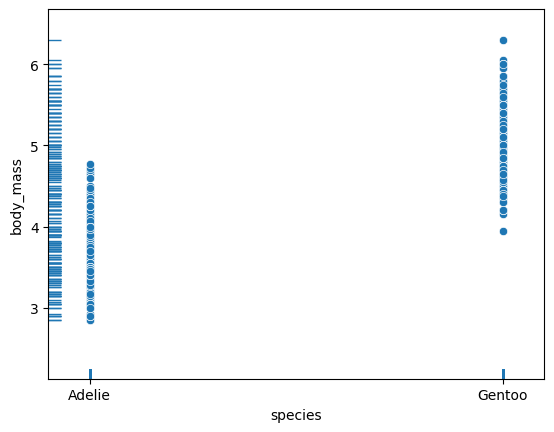

In [ ]:
sns.scatterplot(data=p_data, x="species", y="body_mass")
sns.rugplot(data=p_data, x="species", y="body_mass")
#again just double checking my code did infact work

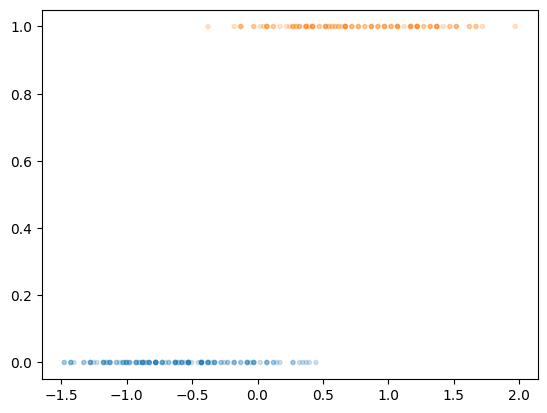

In [ ]:
plt.scatter(body_m_c, species_codes, marker=".", color=[f"C{x}" for x in species_codes], alpha = 0.2)

I'd say that around 0 ish with some favor towards the negative side, any where between -.2 and 0, would be the cutt off point

In [ ]:
with pm.Model() as model_li:
    #Hyperpriors
    q = pm.Uniform("q",upper = 0, lower = -0.2)

    #priors
    α = pm.Normal("α", mu=q, sigma=1)
    β = pm.Normal("β", mu=q, sigma=5)

    #linear part of the model
    μ = α + body_m_c * β

    #the linear part, mu, is transformed via a sigmoid curve
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    #this lets our model find a boudary value
    #which allows us to do classificiation
    #It is not neccesary for the model to run
    bd = pm.Deterministic("bd", -α / β)

    #likelihood
    y = pm.Bernoulli("y", p=θ, observed=species_codes)

    idata_li = pm.sample()
    #I am ripping this model straight from the notess. only really adding thy hyper priors part because I felt that I couldn't point to any specific point

Output()

Output()

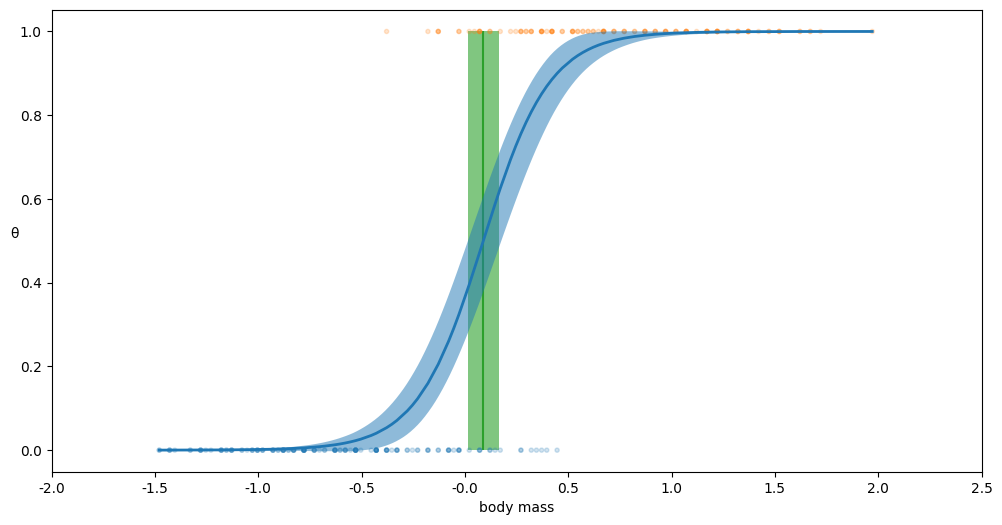

In [ ]:
posterior = idata_li.posterior
theta = posterior["θ"].mean(("chain", "draw"))

#this will help us tanslate from the standardized data back to the raw data
idx = np.argsort(body_m_c)

#set up the plot
_, ax = plt.subplots(figsize=(12, 6))

#plot the posterior
ax.plot(body_m_c[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)

#bd for boundary
#these two lines plot our boundary or decision line, which is what we could use
#to predict the sepcies of a penguin using body mass
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)

#scatter plot of raw data
ax.scatter(body_m_c, species_codes, marker=".", color=[f"C{x}" for x in species_codes], alpha = 0.2)

#plots the sigmoid regression
az.plot_hdi(body_m_c, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})

#labels
ax.set_xlabel('body mass')
ax.set_ylabel("θ", rotation=0)

# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + body_m_c.mean(), 1))

So our eyeball attempt should have been in the opposite direction instead of  veerying negative, though our 0, does fall within our 94%HDI. Our HDI iindicates that our cutt off is from 0 to around 0.2-ish.